In [1]:
!python -V

Python 3.12.2


In [1]:
import setuptools

In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-green-taxi-trip-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716652795814, experiment_id='1', last_update_time=1716652795814, lifecycle_stage='active', name='nyc-green-taxi-trip-experiment', tags={}>

In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.1228220948023795

/tmp/ipykernel_2626/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2626/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


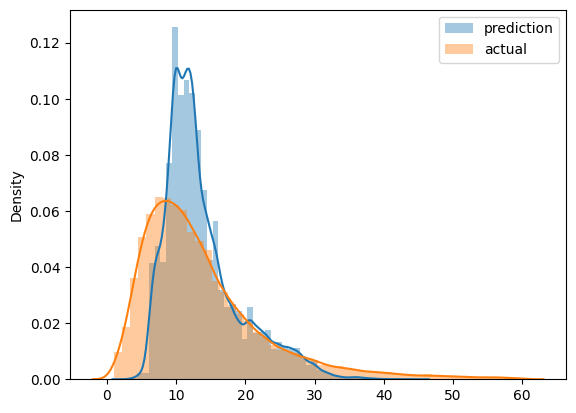

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [7]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet')

In [9]:
len(df_train), len(df_val)

(54373, 51497)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.9947992164797

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


8.029292935675121

In [19]:
with mlflow.start_run():

    # set custom tags to filter runs
    mlflow.set_tag("Developer", "Sreekar")

    # log params that affect the model's performance
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
    mlflow.log_param("val-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    # log metrics for comparing model's performance
    mlflow.log_metric("rmse", rmse)

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [13]:
train = xgb.DMatrix(X_train, label = y_train)
val = xgb.DMatrix(X_val, label = y_val)

In [14]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(val, 'validation')],
            early_stopping_rounds = 100
        )
        y_pred = booster.predict(val)
        rmse = mean_squared_error(y_val, y_pred, squared = False)
        mlflow.log_metric('rmse', rmse)
        
    return {'loss': rmse, 'status': STATUS_OK}

In [15]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 5)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [ ]:
best_result = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 50,
    trials = Trials()
)

In [16]:
# Disabling autolog from xgboost
mlflow.xgboost.autolog(disable = True)

In [17]:
# Running the model again with the best parameters

with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.05151930425386075,
        'max_depth': 25,
        'min_child_weight': 2.1375707556264576,
        'objective': 'reg:linear',
        'reg_alpha': 0.013424620461035791,
        'reg_lambda': 0.0025414854740249348,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=100
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:32:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.80803
[1]	validation-rmse:8.52596
[2]	validation-rmse:8.26389
[3]	validation-rmse:8.02085
[4]	validation-rmse:7.79494
[5]	validation-rmse:7.58638
[6]	validation-rmse:7.39301
[7]	validation-rmse:7.21518
[8]	validation-rmse:7.05120
[9]	validation-rmse:6.89960
[10]	validation-rmse:6.76039
[11]	validation-rmse:6.63257
[12]	validation-rmse:6.51507
[13]	validation-rmse:6.40730
[14]	validation-rmse:6.30847
[15]	validation-rmse:6.21825
[16]	validation-rmse:6.13561
[17]	validation-rmse:6.05963
[18]	validation-rmse:5.99083
[19]	validation-rmse:5.92778
[20]	validation-rmse:5.86955
[21]	validation-rmse:5.81616
[22]	validation-rmse:5.76792
[23]	validation-rmse:5.72364
[24]	validation-rmse:5.68252
[25]	validation-rmse:5.64537
[26]	validation-rmse:5.61150
[27]	validation-rmse:5.58039
[28]	validation-rmse:5.55142
[29]	validation-rmse:5.52518
[30]	validation-rmse:5.50160
[31]	validation-rmse:5.48054
[32]	validation-rmse:5.46003
[33]	validation-rmse:5.44227
[34]	validation-rmse:5.4

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:33:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():
        mlflow.log_param('train-data-path', 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
        mlflow.log_param('val-data-path', 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet')
        mlflow.log_artifact('models/preprocessor.b', artifact_path = 'preprocessor')

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared = False)
        mlflow.log_metric('rmse', rmse)

2024/05/27 18:54:48 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/05/27 18:58:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/python/3.10.13/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
2024/05/27 18:58:43 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be remov